In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0                # gradient of loss (output) wrt current value
        self._backward = lambda: None      # function that defines how to calculate backprop gradient
        self._prev = set(_children)  # terms that make up value
        self._op = _op               # Previous operation
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # check if other is constant or Value obj
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad  # dL/dself = dn/dself * dL/dn
            other.grad += 1.0 * out.grad # dL/dself = dn/dself * dL/dn
            
        out._backward = _backward 
        return out
    
    def __radd__(self, other): # for other * self
        return self * other
    
    def __neg__(self): # for -self
        return self * -1
    
    def __sub__(self, other): # for self - other
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # for other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * (other ** -1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data ** other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def backward(self):
        # find topological ordering of nodes, self as root
        topo = []
        visited = set()
        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)
                
        topo_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [23]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [3]:
from graphviz import Digraph

def trace(root):
    # building nodes/edges of graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    
    build(root)
    
    return nodes, edges

def draw_dot(root):
    # Left to Right
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        (dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" 
                  % (n.label, n.data, n.grad), shape='record'))
        # creating rectangular node for graph values
        if n._op:
            # if result of operation, create opnode
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [24]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# act function
o = n.tanh(); o.label = 'o'

In [25]:
o.backward()

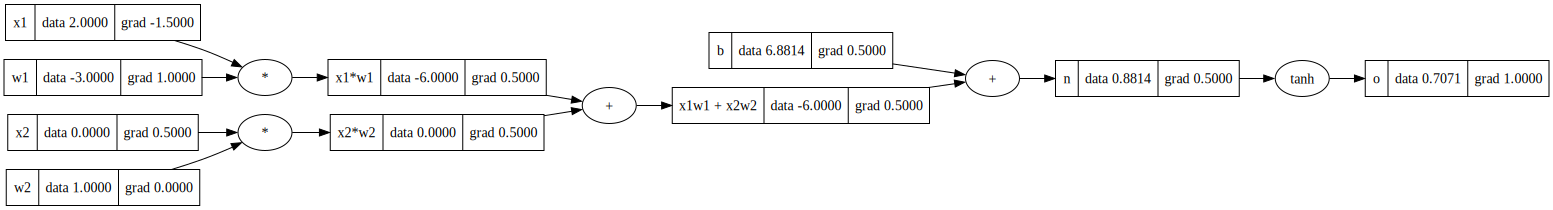

In [26]:
draw_dot(o)

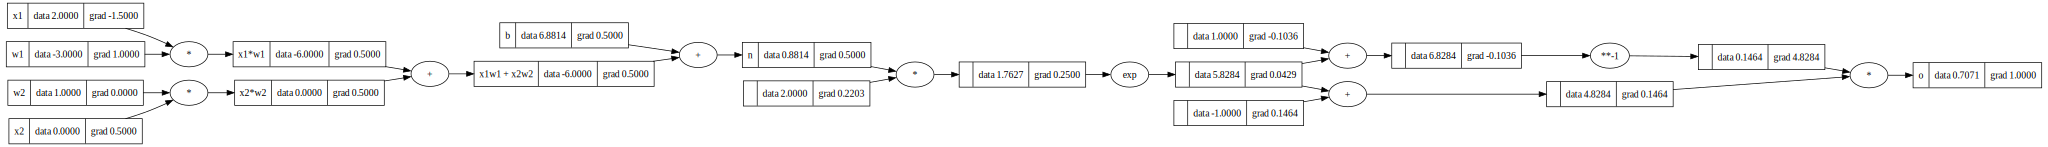

In [27]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# act function, explicit implementation of function tanh
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)